###  Data Import

In [89]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load raw data (Date and Time will be kept as strings for now)
df = pd.read_csv("C:/Users/sharan/Documents/powerpulse_forecast/data/household_power_consumption.txt",
                 sep=';',
                 na_values='?',
                 low_memory=False)

# Combine Date and Time into a single datetime column
df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], dayfirst=True)

# Drop original Date and Time columns
df.drop(columns=['Date', 'Time'], inplace=True)

# Reorder columns so datetime comes first
cols = ['datetime'] + [col for col in df.columns if col != 'datetime']
df = df[cols]

# Convert numeric columns to float
for col in df.columns:
    if col != 'datetime':
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Final check
print(df.dtypes)
df.head()


datetime                 datetime64[ns]
Global_active_power             float64
Global_reactive_power           float64
Voltage                         float64
Global_intensity                float64
Sub_metering_1                  float64
Sub_metering_2                  float64
Sub_metering_3                  float64
dtype: object


,datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [91]:
# Check for nulls
df.isnull().sum()

# Data types
df.dtypes

# Basic stats
df.describe()

# Basic Info
print(df.info())
print(df.describe())
print(df.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 8 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   datetime               datetime64[ns]
 1   Global_active_power    float64       
 2   Global_reactive_power  float64       
 3   Voltage                float64       
 4   Global_intensity       float64       
 5   Sub_metering_1         float64       
 6   Sub_metering_2         float64       
 7   Sub_metering_3         float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 126.7 MB
None
                            datetime  Global_active_power  \
count                        2075259         2.049280e+06   
mean   2008-12-06 07:12:59.999994112         1.091615e+00   
min              2006-12-16 17:24:00         7.600000e-02   
25%              2007-12-12 00:18:30         3.080000e-01   
50%              2008-12-06 07:13:00         6.020000e-01   
75%              2009-12-0

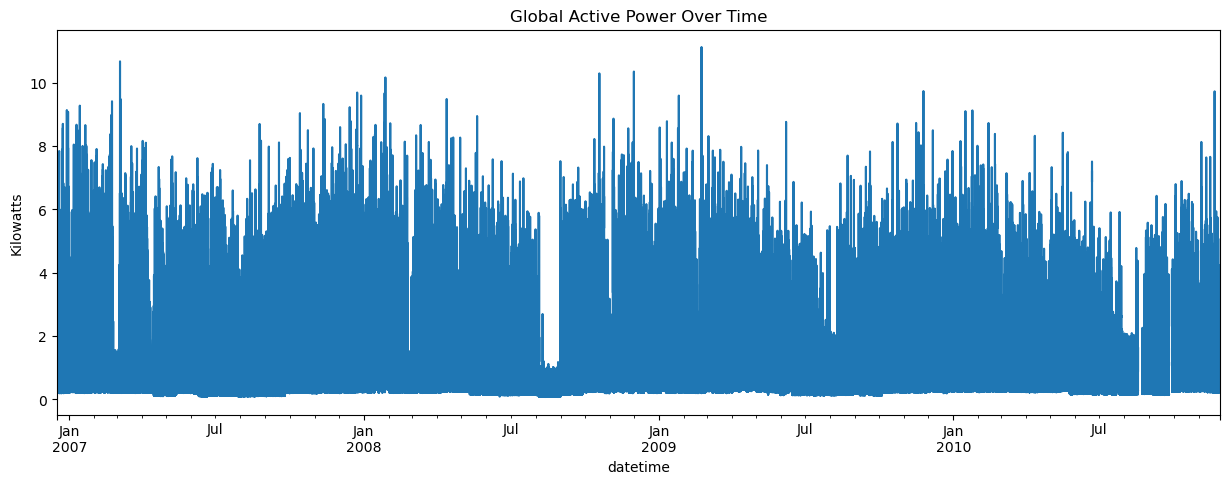

In [92]:
# Line plot of power usage
df['Global_active_power'] = pd.to_numeric(df['Global_active_power'], errors='coerce')
df.set_index('datetime')['Global_active_power'].plot(figsize=(15,5))
plt.title("Global Active Power Over Time")
plt.ylabel("Kilowatts")
plt.show()

In [93]:
df.set_index('datetime', inplace=True)
df = df.sort_index()


### Daily Aggregation
We convert the data into daily averages for better trend analysis and model performance.


In [95]:
# Aggregate to daily mean
daily_df = df.resample('D').mean()

# View result
daily_df.head()


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16,3.053475,0.088187,236.243763,13.082828,0.000000,1.378788,12.439394
2006-12-17,2.354486,0.156949,240.087028,9.999028,1.411806,2.907639,9.264583
2006-12-18,1.530435,0.112356,241.231694,6.421667,0.738194,1.820139,9.734722
2006-12-19,1.157079,0.104821,241.999313,4.926389,0.582639,5.279167,4.303472
2006-12-20,1.545658,0.111804,242.308062,6.467361,0.000000,1.838889,9.765972


### Moving Average Feature
We create a 7-day moving average of global active power to capture short-term trends.


In [97]:
# Moving average
daily_df['Global_active_power_MA7'] = daily_df['Global_active_power'].rolling(window=7).mean()

# Day of week (helps find patterns like weekdays/weekends)
daily_df['day_of_week'] = daily_df.index.dayofweek  # Monday = 0

# Is weekend?
daily_df['is_weekend'] = daily_df['day_of_week'].isin([5, 6]).astype(int)

# Month (seasonality pattern)
daily_df['month'] = daily_df.index.month


In [98]:
print(daily_df.shape)
print(daily_df.isnull().sum())
daily_df.head()


(1442, 11)
Global_active_power         9
Global_reactive_power       9
Voltage                     9
Global_intensity            9
Sub_metering_1              9
Sub_metering_2              9
Sub_metering_3              9
Global_active_power_MA7    45
day_of_week                 0
is_weekend                  0
month                       0
dtype: int64


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Global_active_power_MA7,day_of_week,is_weekend,month
datetime,,,,,,,,,,,
2006-12-16,3.053475,0.088187,236.243763,13.082828,0.000000,1.378788,12.439394,NaN,5,1,12
2006-12-17,2.354486,0.156949,240.087028,9.999028,1.411806,2.907639,9.264583,NaN,6,1,12
2006-12-18,1.530435,0.112356,241.231694,6.421667,0.738194,1.820139,9.734722,NaN,0,0,12
2006-12-19,1.157079,0.104821,241.999313,4.926389,0.582639,5.279167,4.303472,NaN,1,0,12
2006-12-20,1.545658,0.111804,242.308062,6.467361,0.000000,1.838889,9.765972,NaN,2,0,12


### Feature and Target Setup
We define the target variable and the features to be used for regression modeling.


In [100]:
target = 'Global_active_power'
features = [
    'Global_reactive_power',
    'Voltage',
    'Global_intensity',
    'Sub_metering_1',
    'Sub_metering_2',
    'Sub_metering_3',
    'Global_active_power_MA7',
    'day_of_week',
    'is_weekend',
    'month'
]

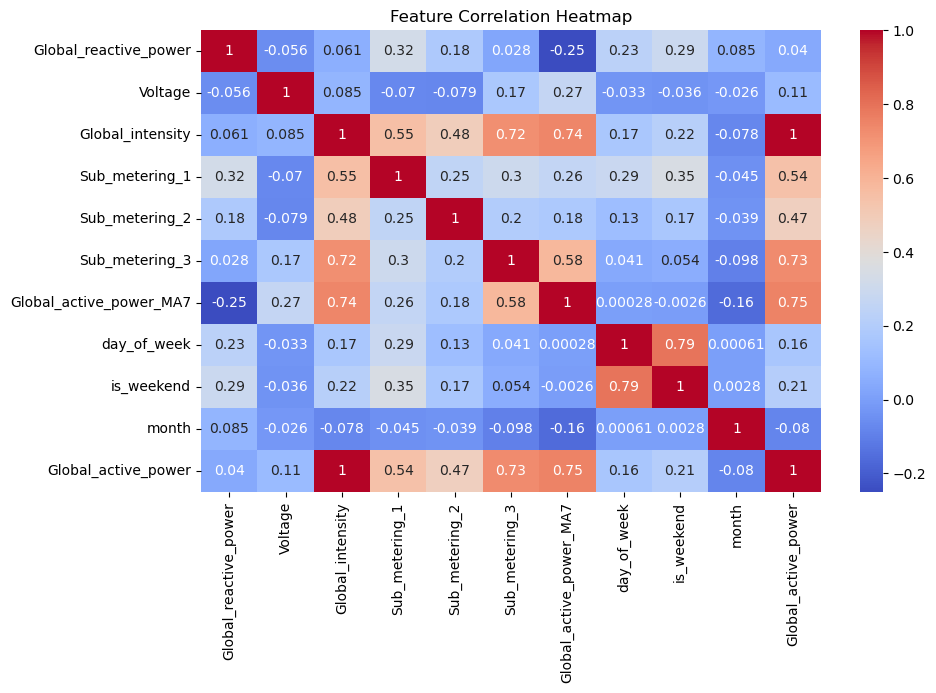

In [101]:
# Only include numeric features
corr_matrix = daily_df[features + [target]].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()



## Training & Evaluation

In [103]:
from sklearn.model_selection import train_test_split

X = daily_df[features].dropna()
y = daily_df.loc[X.index, target]  # aligned target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [104]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [105]:
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (1117, 10)
Test shape: (280, 10)


In [106]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np


In [107]:
def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"{name} Performance:")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE : {mae:.4f}")
    print(f"R²  : {r2:.4f}")
    print("-" * 30)
    
    return rmse, mae, r2


### Linear Regression

In [109]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
evaluate_model("Linear Regression", lr, X_test_scaled, y_test)


Linear Regression Performance:
RMSE: 0.0097
MAE : 0.0072
R²  : 0.9995
------------------------------


(0.00970097462239119, 0.007247079414087076, 0.9995484655054442)

### Random Foreset

In [111]:
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
evaluate_model("Random Forest", rf, X_test, y_test)


Random Forest Performance:
RMSE: 0.0168
MAE : 0.0114
R²  : 0.9986
------------------------------


(0.016818379318670404, 0.011408495412269733, 0.9986428480251608)

### Gradient Boosting

In [113]:
gb = GradientBoostingRegressor(random_state=42)
gb.fit(X_train, y_train)
evaluate_model("Gradient Boosting", gb, X_test, y_test)


Gradient Boosting Performance:
RMSE: 0.0139
MAE : 0.0096
R²  : 0.9991
------------------------------


(0.013944327013047585, 0.009636521727547025, 0.9990670565617373)

### Actual vs Predicted Visualization For Random Forest

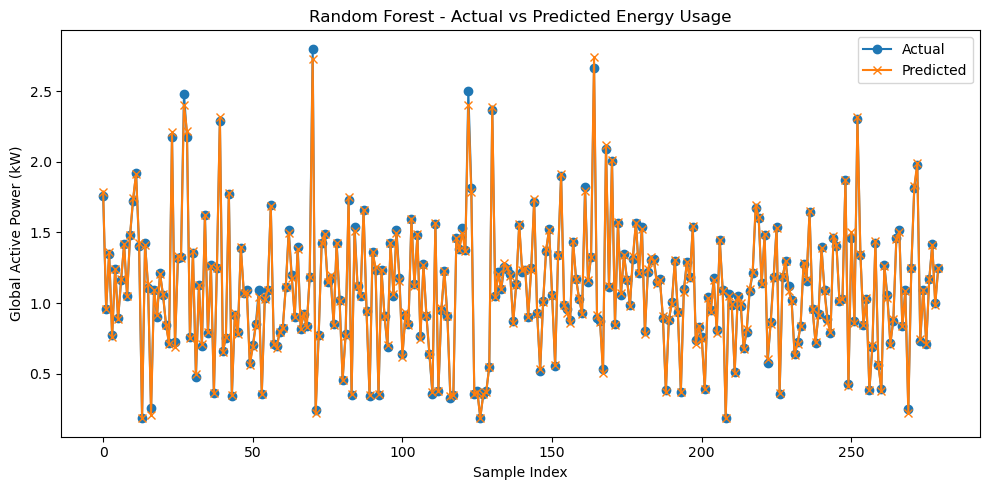

In [115]:
y_pred = rf.predict(X_test)

plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label='Actual', marker='o')
plt.plot(y_pred, label='Predicted', marker='x')
plt.title("Random Forest - Actual vs Predicted Energy Usage")
plt.xlabel("Sample Index")
plt.ylabel("Global Active Power (kW)")
plt.legend()
plt.tight_layout()
plt.show()


In [116]:
from sklearn.model_selection import GridSearchCV


In [117]:
rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
rf_grid = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=rf_params,
    scoring='neg_root_mean_squared_error',
    cv=3,
    n_jobs=-1,
    verbose=1
)

rf_grid.fit(X_train, y_train)
print("Best Parameters (Random Forest):", rf_grid.best_params_)
best_rf = rf_grid.best_estimator_
evaluate_model("Tuned Random Forest", best_rf, X_test, y_test)


Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best Parameters (Random Forest): {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Tuned Random Forest Performance:
RMSE: 0.0168
MAE : 0.0111
R²  : 0.9987
------------------------------


(0.01675155198288636, 0.011089695150030825, 0.9986536118047564)

In [118]:
gb_params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0]
}
gb_grid = GridSearchCV(
    estimator=GradientBoostingRegressor(random_state=42),
    param_grid=gb_params,
    scoring='neg_root_mean_squared_error',
    cv=3,
    n_jobs=-1,
    verbose=1
)

gb_grid.fit(X_train, y_train)
print("Best Parameters (Gradient Boosting):", gb_grid.best_params_)
best_gb = gb_grid.best_estimator_
evaluate_model("Tuned Gradient Boosting", best_gb, X_test, y_test)


Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best Parameters (Gradient Boosting): {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Tuned Gradient Boosting Performance:
RMSE: 0.0134
MAE : 0.0095
R²  : 0.9991
------------------------------


(0.013405711635628585, 0.009491982613962488, 0.9991377366184289)

### Actual vs Predicted Visualization For Linear Regression

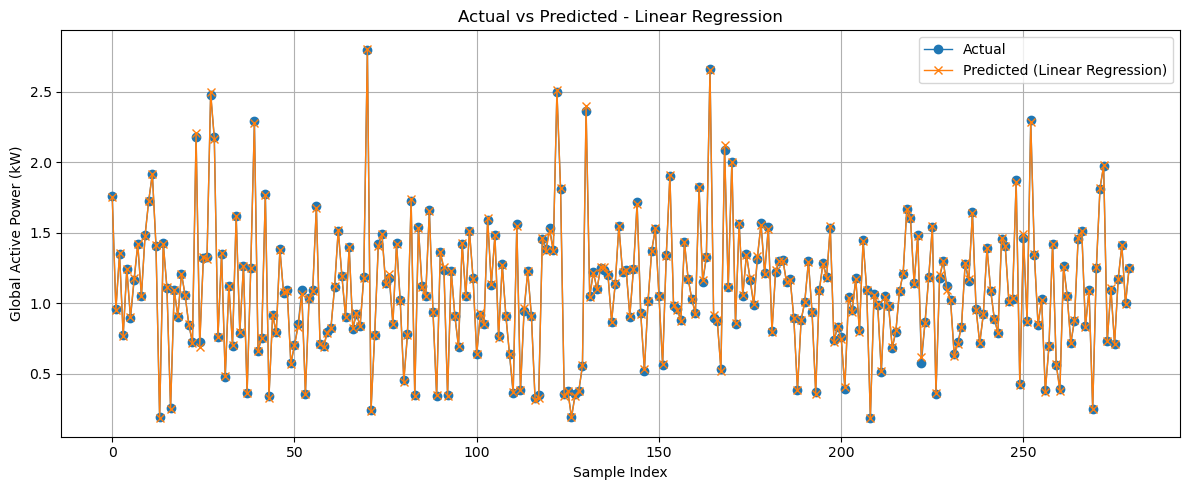

In [120]:
y_pred_lr = lr.predict(X_test_scaled)

plt.figure(figsize=(12, 5))
plt.plot(y_test.values, label='Actual', marker='o', linewidth=1)
plt.plot(y_pred_lr, label='Predicted (Linear Regression)', marker='x', linewidth=1)
plt.title("Actual vs Predicted - Linear Regression")
plt.xlabel("Sample Index")
plt.ylabel("Global Active Power (kW)")
plt.legend()
plt.grid(True)
plt.tight_layout()


plt.savefig("C:/Users/sharan/Documents/powerpulse_forecast/plots/actual_vs_predicted_linear_regression.png")  
plt.show()


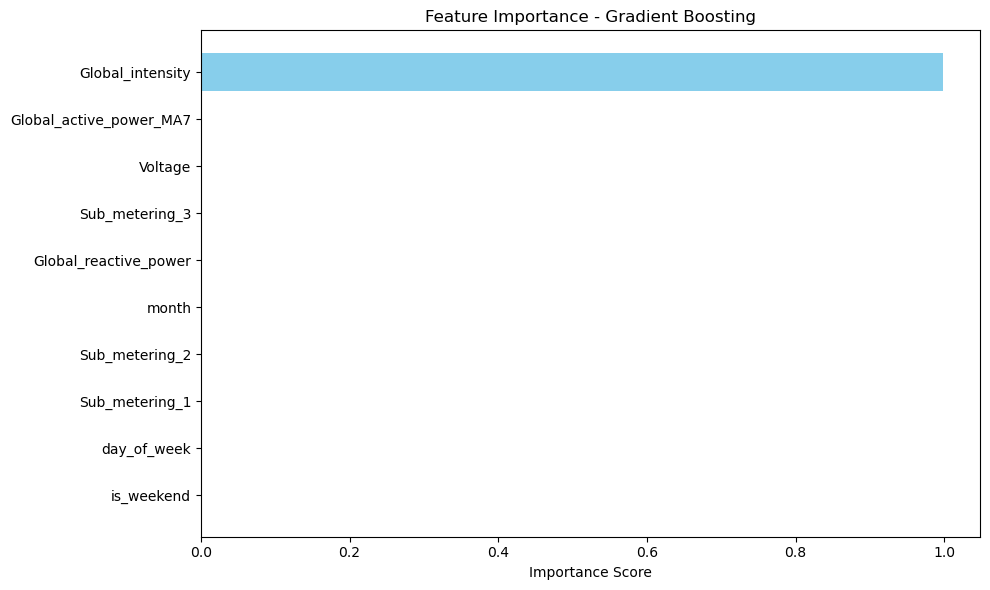

In [121]:
importances = best_gb.feature_importances_
feature_names = X_train.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.gca().invert_yaxis()
plt.title("Feature Importance - Gradient Boosting")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.savefig("C:/Users/sharan/Documents/powerpulse_forecast/plots/feature_importance.png")  
plt.show()
plt.show()


##  Key Insights and Conclusion

- The best performing model is Linear Regression with R² = 0.9995
- Most influential feature: Global_intensity.
- The model can help in energy optimization for households and providers.
